### Accuracy Impacts of Augmentation on Testsets

This notebook uses the models the team trained on augmented datasets to determine what impact evaluating testsets that have also been augmented has on model accuracy.  While the team's focus is on shrinking the distribution gap observed between the CIFAR 10 and 10.1 testsets, the results are examined from two dimensions:
  1. What, if any, effect is observed on the distribution gap when comparing model evaluations on an augemented CIFAR 10 testset to an augmented CIFAR 10.1 tesetset.
  2. What, if any, effect is observed in model accuracy when comparing the model performs predicting classes for the unaugmented CIFAR X testset versus the augmented CIFAR X testset?

In [8]:
import boto3
from collections import defaultdict
import glob
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)

In [9]:
!pip install -r '/home/ec2-user/SageMaker/w210-capstone/models/pytorch_imageclass/requirements.txt'
!pip install tensorboard

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [13]:
# S3 Bucket where the model checkpoints exist (Set based on AWS instance used)
# bucket = 'sagemaker-june29'
bucket = 'sagemaker-june29'

# Directory path within S3 to the model results
prefix = 'sagemaker/results/original-models/'

# Local destination directory 
destdir = '/home/ec2-user/SageMaker/checkpoints/'

# File path to model pytorch files
pytorch_models = '/home/ec2-user/SageMaker/w210-capstone/models/pytorch_imageclass/'

# Dictionary to look up matching config files with
config_files = defaultdict(lambda: "default", key="skip")

config_files['wrn_28_10'] = "wrn.yaml"
config_files['resnet_basic_32'] = "resnet.yaml"
config_files['densenet_BC_100_12'] = "densenet.yaml"
config_files['resnext_29_4x64d'] =  "resnext.yaml"

In [172]:
# Retrieve a list the checkpoint files 
def get_chpt_files(bucket, prefix):

    s3 = boto3.client('s3')
    refined_checkpoints = []
    basetraining_checkpoints = []
    kwargs = {'Bucket': bucket, 'Prefix': prefix}

    resp = s3.list_objects_v2(**kwargs)
    for obj in resp['Contents']:
        key = obj['Key']
        if key.endswith("00400.pth"):
            basetraining_checkpoints.append(key)
        if key.endswith("00050.pth"):
            refined_checkpoints.append(key)
            
    return basetraining_checkpoints, refined_checkpoints



# Download a checkpoint file and write it to the destination directory
def download_chpt(bucket, destdir, file):
    s3 = boto3.resource('s3')
    filesplit = file.split("/")
    filename = str(filesplit[-1])
    model = str(filesplit[3])
    destination = destdir + model + '_' + filename
    s3.Bucket(bucket).download_file(file, destination)


In [173]:
# Create the destination directory if it doesn't exist
if not os.path.exists(destdir):
        os.mkdir(destdir)

# Download the model checkpoints
basetraining_checkpoints, refined_checkpoints = get_chpt_files(bucket, prefix)

for cp in basetraining_checkpoints + refined_checkpoints:
    download_chpt(bucket, destdir, cp)

In [174]:
os.chdir(destdir)
listing = glob.glob(destdir + "*pth")

RA_2_5_Datasets = ['CIFAR10_RA_2_5', 'CIFAR101_RA_2_5']
RA_1_20_Datasets = ['CIFAR10_RA_1_20', 'CIFAR101_RA_1_20']
RA_2_20_Datasets = ['CIFAR10_RA_2_20', 'CIFAR101_RA_2_20']
RA_3_20_Datasets = ['CIFAR10_RA_3_20', 'CIFAR101_RA_3_20']

In [175]:
result = None

def evalute_models(datasets, checkpoints):
    for ds in datasets:
        for chpt in checkpoints:
            
            print(chpt)

            filesplit = chpt.split("/")
            filename = str(filesplit[-1])
            model = filename.split("_")[0]

            os.chdir(pytorch_models)
            results_folder = '/home/ec2-user/SageMaker/experiments/augmented_testsets/' +  filename

            if 'wrn_28_10' in filename:
                print("Test dataset:", ds)
                !python evaluate.py --config configs/cifar/wrn.yaml \
                   model.wrn.depth 28 \
                   model.wrn.widening_factor 10 \
                   dataset.name $ds \
                   test.checkpoint $chpt \
                   test.output_dir $results_folder

            elif 'resnet_basic_32' in filename: 
                print("Test dataset:", ds)
                !python evaluate.py --config configs/cifar/resnet.yaml \
                   model.resnet.depth 32 \
                   test.batch_size 128 \
                   dataset.name $ds \
                   test.checkpoint $chpt \
                   test.output_dir $results_folder

            elif 'densenet_BC_100_12' in filename:
                print("Test dataset:", ds)
                !python evaluate.py --config configs/cifar/densenet.yaml \
                   model.densenet.depth 100 \
                   model.densenet.growth_rate 12 \
                   test.batch_size 64 \
                   dataset.name $ds \
                   test.checkpoint $chpt \
                   test.output_dir $results_folder

            elif 'resnext_29_4x64d' in filename:
                print("Test dataset:", ds)
                !python evaluate.py --config configs/cifar/resnext.yaml \
                   model.resnext.cardinality 4 \
                   test.batch_size 128 \
                   dataset.name $ds \
                   test.checkpoint $chpt \
                   test.output_dir $results_folder


In [176]:
%%capture cap --no-stderr

evalute_models(RA_1_20_Datasets, [s for s in listing if 'ra_1_20' in s])
evalute_models(RA_2_20_Datasets, [s for s in listing if 'ra_2_20' in s])
evalute_models(RA_3_20_Datasets, [s for s in listing if 'ra_3_20' in s])
evalute_models(RA_2_5_Datasets, [s for s in listing if 'ra_2_5' in s])


In [177]:
with open('output.txt', 'w') as f:
     f.write(cap.stdout)

In [178]:
p = re.compile("Loss (.*) Accuracy (.*)\r")
result = p.findall(cap.stdout)

q = re.compile("/home/ec2-user/SageMaker/checkpoints/(.*)\r")
result2 = q.findall(cap.stdout)

r = re.compile("Test dataset: (.*)\n")
result3 = r.findall(cap.stdout)

acc = [e+(r2,r3) for e,r2,r3 in zip(result, result2, result3)]

In [28]:
df = pd.DataFrame(acc, columns =['Loss', 'Accuracy', 'Checkpoint', 'Testset'])
df.to_csv('/home/ec2-user/SageMaker/experiments/augmented_testsets/augmentedtestsets_results.csv')
df

,Loss,Accuracy,Checkpoint,Testset
0,2.3030,0.4961,resnet_basic_32_ra_1_20_c10val_checkpoint_0005...,CIFAR10_RA_1_20
1,1.5681,0.6371,resnet_basic_32_ra_1_20_c10val_checkpoint_0040...,CIFAR10_RA_1_20
2,1.4069,0.6134,wrn_28_10_ra_1_20_c10val_checkpoint_00050.pth,CIFAR10_RA_1_20
3,0.9208,0.6958,resnext_29_4x64d_ra_1_20_c10val_checkpoint_004...,CIFAR10_RA_1_20
4,2.2835,0.4403,resnext_29_4x64d_ra_1_20_c10val_checkpoint_000...,CIFAR10_RA_1_20
5,0.9903,0.7016,wrn_28_10_ra_1_20_c10val_checkpoint_00400.pth,CIFAR10_RA_1_20
6,3.1327,0.4200,resnet_basic_32_ra_1_20_c10val_checkpoint_0005...,CIFAR101_RA_1_20
7,6.8044,0.3310,resnet_basic_32_ra_1_20_c10val_checkpoint_0040...,CIFAR101_RA_1_20
8,1.9904,0.5495,wrn_28_10_ra_1_20_c10val_checkpoint_00050.pth,CIFAR101_RA_1_20
9,2.5599,0.3955,resnext_29_4x64d_ra_1_20_c10val_checkpoint_004...,CIFAR101_RA_1_20


In [24]:
# Move the results to the appropriate file in the GitHub Repo
if bucket == 'sagemaker-june29':
    !cp '/home/ec2-user/SageMaker/experiments/augmented_testsets/augmentedtestsets_results.csv' '/home/ec2-user/SageMaker/w210-capstone/analysis/supporting_data/augmentedtestset_results1.csv'
elif bucket == 'sagemaker-may29':
    !cp '/home/ec2-user/SageMaker/experiments/augmented_testsets/augmentedtestsets_results.csv' '/home/ec2-user/SageMaker/w210-capstone/analysis/supporting_data/augmentedtestset_results2.csv'
else:
    print("New bucket!  Please register with script.")  

#### Aggregate Results for Analysis

In [183]:
i = []
df1 = pd.read_csv('/home/ec2-user/SageMaker/w210-capstone/analysis/supporting_data/augmentedtestset_results1.csv')
df2 = pd.read_csv('/home/ec2-user/SageMaker/w210-capstone/analysis/supporting_data/augmentedtestset_results2.csv') 

df = pd.concat([df1, df2], axis=0, ignore_index=True)
df.head()

,Unnamed: 0,Loss,Accuracy,Checkpoint,Testset
0,0,2.3030,0.4961,resnet_basic_32_ra_1_20_c10val_checkpoint_00050.pth,CIFAR10_RA_1_20
1,1,1.5681,0.6371,resnet_basic_32_ra_1_20_c10val_checkpoint_00400.pth,CIFAR10_RA_1_20
2,2,1.4069,0.6134,wrn_28_10_ra_1_20_c10val_checkpoint_00050.pth,CIFAR10_RA_1_20
3,3,0.9208,0.6958,resnext_29_4x64d_ra_1_20_c10val_checkpoint_00400.pth,CIFAR10_RA_1_20
4,4,2.2835,0.4403,resnext_29_4x64d_ra_1_20_c10val_checkpoint_00050.pth,CIFAR10_RA_1_20


In [184]:
# Filter columns to those we need for analysis
df = df[['Checkpoint', 'Accuracy', 'Loss', 'Testset']].sort_values(by=['Checkpoint'])

# Remove models that we did not run randaugment datasets through
df = df[~df["Checkpoint"].str.contains('resnet_basic_44')]
df = df[~df["Checkpoint"].str.contains('pyramidnet_basic_110_84')]
df = df[~df["Checkpoint"].str.contains('resnext_29_8x64d')]


df['cm'] = df['Checkpoint'].str.contains("_cm_")
df['ra'] = df['Checkpoint'].str.contains("ra_")
df['val'] = df['Checkpoint'].str.contains("_c10val")
df['refined'] = df['Checkpoint'].str.contains("00050")

def ra_N_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    N=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Checkpoint'].lower())
        N = int(srch3.group(1))
    return N

def ra_M_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    M=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Checkpoint'].lower())
        M = int(srch3.group(2))
    return M

def cm_Alpha_extraction(row):
    p4 = re.compile("cm_(\d+)_([\.\d]+)")
    alpha = 0
    if row['cm'] == True :
        srch4 = p4.search(row['Checkpoint'].lower())
        alpha = float(srch4.group(2))
    return alpha

def model_name(row):
    return row.Checkpoint.split('_')[0]

def chart_name(row):
    newname = newname = row.Checkpoint.split('_')[0]
    if row['ra'] == False:
        newname += " Original Model"
    else:
        if row['refined'] == True :
            newname += " Train: RA N=" + str(row['N']) + ",M=" + str(row['M']) + " + Unaugmented Refine"
        else:
            newname += " Train: RA N=" + str(row['N']) + ",M=" + str(row['M'])

        if row['val'] == True:
            newname += "; Val: Unaugmented"
        else:
            newname += "; Val: Augmented"        
    return newname
    
df['N'] = df.apply(lambda row: ra_N_extraction(row), axis=1)
df['M'] = df.apply(lambda row: ra_M_extraction(row), axis=1)
df['Alpha'] = df.apply(lambda row: cm_Alpha_extraction(row), axis=1)
df['ModelName'] = df.apply(lambda row: model_name(row), axis=1)
df['ChartName'] = df.apply(lambda row: chart_name(row), axis=1)
cols = ['N','M']
df['hue'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

df = df.sort_values(by=['ModelName', "N", "M"])

In [185]:
df.head()

,Checkpoint,Accuracy,Loss,Testset,cm,ra,val,refined,N,M,Alpha,ModelName,ChartName,hue
74,densenet_BC_100_12_ra_1_20_c10val_checkpoint_00050.pth,0.5303,2.1353,CIFAR10_RA_1_20,False,True,True,True,1,20,0,densenet,"densenet Train: RA N=1,M=20 + Unaugmented Refine; Val: Unaugmented",1_20
78,densenet_BC_100_12_ra_1_20_c10val_checkpoint_00050.pth,0.5010,2.6572,CIFAR101_RA_1_20,False,True,True,True,1,20,0,densenet,"densenet Train: RA N=1,M=20 + Unaugmented Refine; Val: Unaugmented",1_20
75,densenet_BC_100_12_ra_1_20_c10val_checkpoint_00400.pth,0.6988,1.1273,CIFAR10_RA_1_20,False,True,True,False,1,20,0,densenet,"densenet Train: RA N=1,M=20; Val: Unaugmented",1_20
79,densenet_BC_100_12_ra_1_20_c10val_checkpoint_00400.pth,0.4565,3.2946,CIFAR101_RA_1_20,False,True,True,False,1,20,0,densenet,"densenet Train: RA N=1,M=20; Val: Unaugmented",1_20
73,densenet_BC_100_12_ra_1_20_checkpoint_00050.pth,0.4792,2.3043,CIFAR10_RA_1_20,False,True,False,True,1,20,0,densenet,"densenet Train: RA N=1,M=20 + Unaugmented Refine; Val: Augmented",1_20


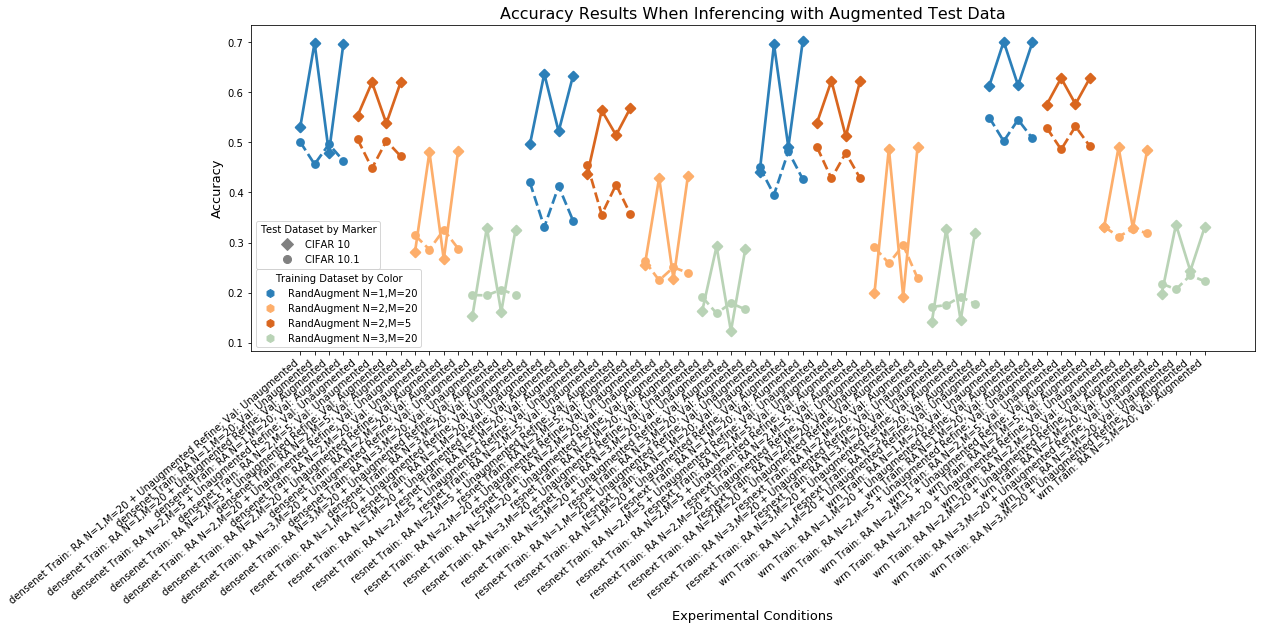

In [186]:
flatui = ["#2c7fb8", "#fdae6b", "#D9661F", "#B9D3B6", "#B9D3B6", "#859438"]

f, ax = plt.subplots(figsize=(18, 6))
sp = sns.pointplot(x="ChartName", hue="hue", y="Accuracy", data=df[df['Testset'].str.contains("CIFAR10_")], 
                   markers=['D'] * 4, linestyles=['-']*4, palette=flatui, ci=None)  

plt.ylabel('Accuracy', fontsize=13)
plt.title('Accuracy Results When Inferencing with Augmented Test Data', fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
sns.set_style()

sp = sns.pointplot(x="ChartName", hue="hue", y="Accuracy", data=df[df['Testset'].str.contains("CIFAR101")], 
                   markers=['o']*4, linestyles=['--']*4, palette=flatui, ci=None,alpha=0.7) # and slightly transparent

plt.xlabel('Experimental Conditions', fontsize=13)

train_datasets = ['RandAugment N=1,M=20', 'RandAugment N=2,M=20', 'RandAugment N=2,M=5', 'RandAugment N=3,M=20']
test_datasets = ['CIFAR 10', 'CIFAR 10.1']

h = [plt.plot([],[], color=c, marker="h", ms=8, ls="")[0] for i,c in zip(train_datasets, flatui)]
leg = ax.legend(handles=h, labels=train_datasets,loc=(.005,.01), title="Training Dataset by Color")
ax.add_artist(leg)

h2 = [plt.plot([],[], color='grey', marker=m, ms=8, ls="")[0] for i,m in zip(test_datasets, ['D', 'o'])]
ax.legend(handles=h2, labels=test_datasets,loc=(.005,0.251), title="Test Dataset by Marker")

pass

Observations:
 * The unaugmented refine phase has a substantial impact on creating the distribution gap 
   - The CIFAR 10.1 scores are far more stable across experiments (e.g., augmented/unaugmented data for validation during training; refine with unaugmented data or not)
     - The line is more stable the greater number of transformations & magnitude
   - This coincides with the idea that the original CIFAR 10 Training Dataset is more similar to the CIFAR 10 Testset than the CIFAR 10.1 Testset

In [187]:
original_df = df[df["Checkpoint"].str.contains('_ra_1_20')]
pd.set_option('display.max_colwidth', -1)
original_df[['Checkpoint','Accuracy', 'Testset']].sort_values(by=['Checkpoint'])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


,Checkpoint,Accuracy,Testset
74,densenet_BC_100_12_ra_1_20_c10val_checkpoint_00050.pth,0.5303,CIFAR10_RA_1_20
78,densenet_BC_100_12_ra_1_20_c10val_checkpoint_00050.pth,0.5010,CIFAR101_RA_1_20
75,densenet_BC_100_12_ra_1_20_c10val_checkpoint_00400.pth,0.6988,CIFAR10_RA_1_20
79,densenet_BC_100_12_ra_1_20_c10val_checkpoint_00400.pth,0.4565,CIFAR101_RA_1_20
73,densenet_BC_100_12_ra_1_20_checkpoint_00050.pth,0.4792,CIFAR10_RA_1_20
77,densenet_BC_100_12_ra_1_20_checkpoint_00050.pth,0.4965,CIFAR101_RA_1_20
72,densenet_BC_100_12_ra_1_20_checkpoint_00400.pth,0.6957,CIFAR10_RA_1_20
76,densenet_BC_100_12_ra_1_20_checkpoint_00400.pth,0.4635,CIFAR101_RA_1_20
0,resnet_basic_32_ra_1_20_c10val_checkpoint_00050.pth,0.4961,CIFAR10_RA_1_20
6,resnet_basic_32_ra_1_20_c10val_checkpoint_00050.pth,0.4200,CIFAR101_RA_1_20


#### Impact of Extended Training Epochs

In [57]:
path = "/home/ec2-user/SageMaker/experiments/densenet_BC_100_12_ra_2_20/exp0"
chpts = [os.path.join(path + '0', f) for f in os.listdir(path + '0') if os.path.isfile(os.path.join(path + '0', f)) and  f.endswith(".pth")]
chpts += [os.path.join(path + '1', f) for f in os.listdir(path + '1') if os.path.isfile(os.path.join(path + '1', f)) and  f.endswith(".pth")]
chpts.sort()

In [58]:
%%capture cap --no-stderr

for ds in RA_2_20_Datasets:
    for chpt in chpts:

        print(chpt)

        filesplit = chpt.split("/")
        filename = str(filesplit[5])
        training_epochs = str(filesplit[-1])
        model = filename.split("_")[0]

        os.chdir(pytorch_models)
        results_folder = '/home/ec2-user/SageMaker/experiments/extended_training/' +  filename + "_" + training_epochs
        print(results_folder)

        if 'densenet_BC_100_12' in filename:
            print("Test dataset:", ds)
            !python evaluate.py --config configs/cifar/densenet.yaml \
               model.densenet.depth 100 \
               model.densenet.growth_rate 12 \
               test.batch_size 64 \
               dataset.name $ds \
               test.checkpoint $chpt \
               test.output_dir $results_folder
        else:
            print("ERROR")

In [59]:
with open('extended_training.txt', 'w') as f:
     f.write(cap.stdout)

In [60]:
p = re.compile("Loss (.*) Accuracy (.*)\r")
result = p.findall(cap.stdout)

q = re.compile("/home/ec2-user/SageMaker/experiments/extended_training/(.*)\n")
result2 = q.findall(cap.stdout)

r = re.compile("Test dataset: (.*)\n")
result3 = r.findall(cap.stdout)

acc = [e+(r2,r3) for e,r2,r3 in zip(result, result2, result3)]

In [63]:
df = pd.DataFrame(acc, columns =['Loss', 'Accuracy', 'Checkpoint', 'Testset'])
df.to_csv('/home/ec2-user/SageMaker/experiments/extended_training/augmentedtestsets_extendedtraining_results.csv')
df

,Loss,Accuracy,Checkpoint,Testset
0,1.5644,0.4336,densenet_BC_100_12_ra_2_20_checkpoint_00100.pth,CIFAR10_RA_2_20
1,1.7676,0.4753,densenet_BC_100_12_ra_2_20_checkpoint_00200.pth,CIFAR10_RA_2_20
2,1.8928,0.4804,densenet_BC_100_12_ra_2_20_checkpoint_00300.pth,CIFAR10_RA_2_20
3,1.9671,0.4834,densenet_BC_100_12_ra_2_20_checkpoint_00400.pth,CIFAR10_RA_2_20
4,1.9929,0.4818,densenet_BC_100_12_ra_2_20_checkpoint_00500.pth,CIFAR10_RA_2_20
5,1.9850,0.4827,densenet_BC_100_12_ra_2_20_checkpoint_00600.pth,CIFAR10_RA_2_20
6,1.9831,0.4818,densenet_BC_100_12_ra_2_20_checkpoint_00700.pth,CIFAR10_RA_2_20
7,1.9949,0.4816,densenet_BC_100_12_ra_2_20_checkpoint_00800.pth,CIFAR10_RA_2_20
8,2.0125,0.4826,densenet_BC_100_12_ra_2_20_checkpoint_00900.pth,CIFAR10_RA_2_20
9,1.9957,0.4831,densenet_BC_100_12_ra_2_20_checkpoint_01000.pth,CIFAR10_RA_2_20


In [152]:
# If we need to re-read in the data
#df = pd.read_csv('/home/ec2-user/SageMaker/w210-capstone/analysis/supporting_data/augmentedtestsets_extendedtraining_results.csv')
#df.drop('Unnamed: 0', axis=1, inplace=True)

In [171]:
def epochs(row):
    e =  row.Checkpoint.split('_')[-1]
    return int(e.split('.')[0])
    
df['epochs'] = df.apply(lambda row: epochs(row), axis=1)

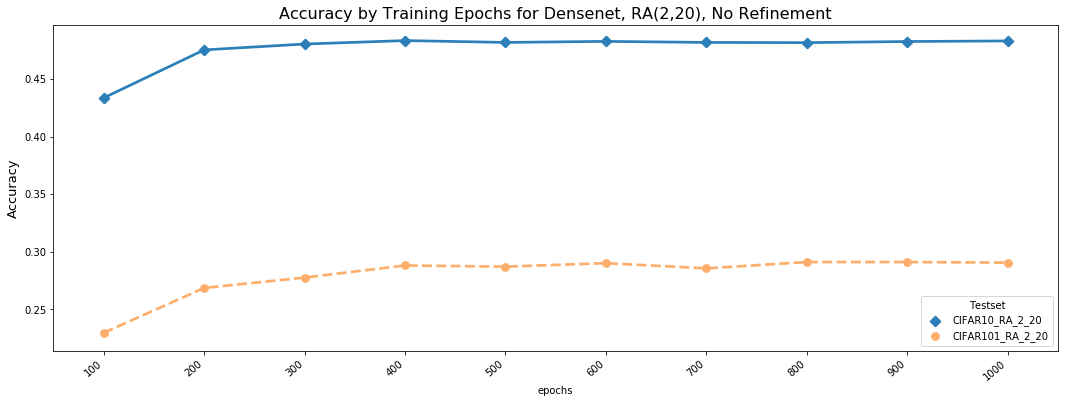

In [170]:
flatui = ["#2c7fb8", "#fdae6b", "#D9661F", "#B9D3B6", "#B9D3B6", "#859438"]

f, ax = plt.subplots(figsize=(18, 6))
sp = sns.pointplot(x="epochs", hue="Testset", y="Accuracy", data=df[df['Testset'].str.contains("CIFAR10_")], 
                   markers=['D'] * 4, linestyles=['-']*4, palette=flatui, ci=None)  

plt.ylabel('Accuracy', fontsize=13)
plt.title('Accuracy by Training Epochs for Densenet, RA(2,20), No Refinement', fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
sns.set_style()

sp = sns.pointplot(x="epochs", hue="Testset", y="Accuracy", data=df[df['Testset'].str.contains("CIFAR101_")], 
                    markers=['o']*4, linestyles=['--']*4, palette=flatui[1:], ci=None,alpha=0.7) # and slightly transparent

pass